## Scratching Learning

In [1]:
from data_processer import *
import torch
from transformers import (
    PatchTSTConfig, 
    PatchTSTForClassification,
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback
 )

2025-03-18 09:15:05.272340: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/ubuntu/anaconda3/envs/gpt/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/ubuntu/anaconda3/envs/g

In [2]:
data_path = "data"
ts_processor = TS_Processor(sequence_length=1024, stride=64, remove_extreme_values=True, iqr_threshold=10.0)
dataset_dict = ts_processor(data_path)

print(dataset_dict)

Detected and removed outliers:
File: 20nm_degree_40.csv, Index: 0, Data: {'time': '2024-12-04 16:14:39.579.', '2-1[m/s^2]': 29.76894, '2-2[m/s^2]': -990.73804, '2-3[m/s^2]': 2.5759, '2-4[m/s^2]': 1015.4796, '2-5[m/s^2]': 0.23558, '2-6[m/s^2]': 0.02296}
File: 100nm_degree_80.csv, Index: 0, Data: {'time': '2024-12-04 18:18:00.273.', '2-1[m/s^2]': 33.15849, '2-2[m/s^2]': 0.58145, '2-3[m/s^2]': -0.53943, '2-4[m/s^2]': -1014.426, '2-5[m/s^2]': -0.22313, '2-6[m/s^2]': 1003.5881}
File: 100nm_degree_40.csv, Index: 0, Data: {'time': '2024-12-04 16:27:52.112.', '2-1[m/s^2]': 31.60742, '2-2[m/s^2]': 991.20013, '2-3[m/s^2]': 1017.3141, '2-4[m/s^2]': 1015.8311, '2-5[m/s^2]': 1003.2505, '2-6[m/s^2]': -1.00929}
File: 60nm_degree_60.csv, Index: 0, Data: {'time': '2024-12-04 17:04:45.059.', '2-1[m/s^2]': -2.50719, '2-2[m/s^2]': -990.35828, '2-3[m/s^2]': 4.05837, '2-4[m/s^2]': 1013.4236, '2-5[m/s^2]': 1003.9898, '2-6[m/s^2]': -1002.5587}
File: 20nm_degree_60.csv, Index: 0, Data: {'time': '2024-12-04 17:

In [3]:
config = PatchTSTConfig(
    num_input_channels=len(dataset_dict["train"][0]["sequence"][0]), 
    num_targets=len(set(dataset_dict["train"]["label"])), 
    context_length=len(dataset_dict["train"][0]["sequence"]), 
    patch_length=16,
    stride=16,
    use_cls_token=True,
    num_hidden_layers=3,
    d_model=128,
    num_attention_heads=4,
    ffn_dim=512
)
model = PatchTSTForClassification(config=config)

training_args = TrainingArguments(
    output_dir="./results_patchtst",
    evaluation_strategy="steps", 
    eval_steps=200, 
    save_strategy="steps", 
    save_steps=200,
    load_best_model_at_end=True, 
    metric_for_best_model="eval_loss", 
  #  greater_is_better=True, 
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=7,
    weight_decay=0.01,
    logging_dir="./logs_patchtst",
    logging_steps=50,
    save_total_limit=2,
    label_names=["target_values"],
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=15)]
)

/home/ubuntu/anaconda3/envs/gpt/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [5]:
trainer.train(resume_from_checkpoint="results_patchtst/checkpoint-9600")

Step,Training Loss,Validation Loss,Accuracy
9800,0.020700,0.047939,0.984088
10000,0.008800,0.047417,0.984333
10200,0.017900,0.072251,0.981395
10400,0.019800,0.049277,0.985435
10600,0.012100,0.050810,0.984088
10800,0.012000,0.030766,0.987515
11000,0.009400,0.042646,0.986047
11200,0.013900,0.033486,0.988127
11400,0.005500,0.030126,0.989106
11600,0.022800,0.053367,0.985190


KeyboardInterrupt: 

In [6]:
test_results = trainer.evaluate(eval_dataset=dataset_dict["test"])
print(test_results)

{'eval_loss': 0.06111611798405647, 'eval_accuracy': 0.9850764377578257}


In [1]:
from transformers import PatchTSTForClassification

model = PatchTSTForClassification.from_pretrained("results_patchmixer/checkpoint-8800")


2025-03-16 20:30:53.268858: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/ubuntu/anaconda3/envs/gpt/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/ubuntu/anaconda3/envs/g

In [2]:
model.num_parameters()

257673

Plot saved to ./plot/patchtst_result.pdf


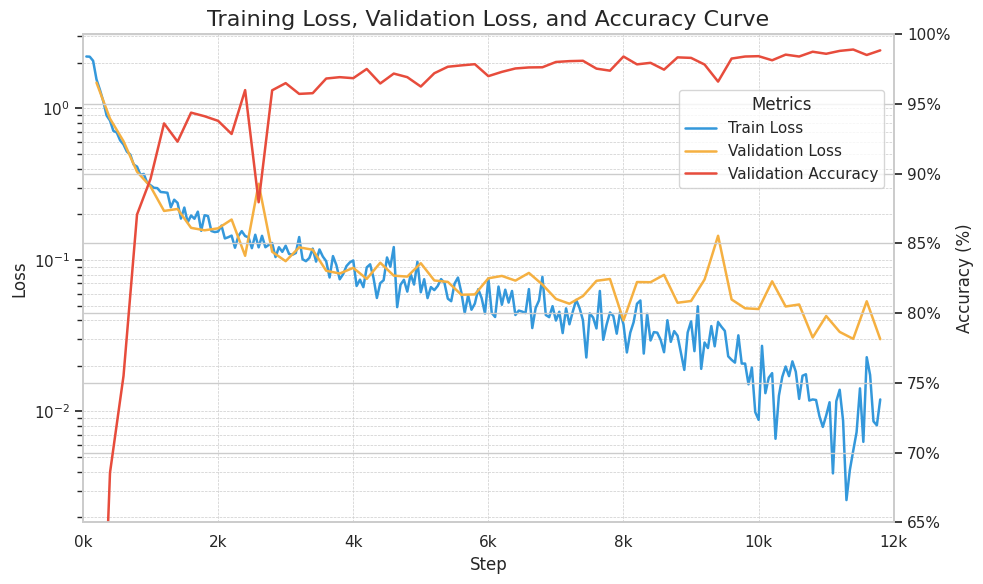

In [1]:
from plot_results import plot_training_results

path = "results_patchtst/checkpoint-11800"
plot_training_results(checkpoint_path=path, save_plot=True, plot_name="patchtst_result")